# Overview
- Build a machine learning pipeline that uses historical transaction data to predict whether a customer will become a repeat buyer.
- Repeat buyers drive a significant share of revenue — identifying them early allows the business to run targeted retention campaigns, personalized offers, and allocate marketing spend more efficiently.

### How this will benefit the client
- Personalized Offers — Customers identified as likely to repeat can receive relevant loyalty offers, tailored product recommendations, or exclusive perks — improving their experience.
-  Proactive Retention — Customers flagged as unlikely to repeat can be engaged with reminders, special discounts, or support outreach to re-engage them — reducing churn.

### Quantifiable Metric 
- By identifying customers with high or low repeat purchase likelihood immediately after their first order, the business can target retention actions (discounts, follow-up emails, loyalty perks) to increase the percentage of repeat buyers. Even a modest lift of 5–10% in repeat purchase rate can directly increase Customer Lifetime Value (CLV) by 10–20% for that segment
- - If deployed, this repeat purchase prediction model can help increase the repeat purchase rate by 5–10% for at-risk segments, driving a projected lift of 8–12% in Customer Lifetime Value (CLV) for targeted customer cohorts

#### Addition to Slides
- “Increase repeat purchase rate by +5% → +8% uplift in average Customer Lifetime Value.”

# Calculate Metric
- - Suppose:
1. Current repeat purchase rate: 30%
2. Average CLV for repeat buyer: €200
3. Average CLV for one-time buyer: €50

- If your model enables you to convert just 5% more first-time buyers to repeat buyers:
- For every 1,000 new customers:
1. Without model: 300 repeat → €60,000 + 700 one-time → €35,000 → Total CLV: €95,000
2. With model: 350 repeat → €70,000 + 650 one-time → €32,500 → Total CLV: €102,500
3.  That’s +€7,500 per 1,000 new customers — 7.9% revenue lift.

#### Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

### Load the dataset and transform

In [3]:
# Load dataset
df = pd.read_excel('Online Retail.xlsx')

# Make sure the customer id does not have null
df = df[df['CustomerID'].notnull()]

# Make sure the quantity and unitprice is bigger than 0
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


In [4]:
# Compute how much customers spend
df['TotalSpending'] = df['Quantity'] * df['UnitPrice']

# Turn the invoice date to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [5]:
# Get the first purchase only

# Sort the values by CustomerId and invoice Date
df = df.sort_values(['CustomerID', 'InvoiceDate'])

# take only the first purchase
first_orders = df.groupby('CustomerID').first().reset_index()


In [6]:
# Count the invoices for each customer
invoice_counts = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Find from the invoices which customer are repeatable
invoice_counts['RepeatBuyer'] = invoice_counts['InvoiceNo'].apply(lambda x: 1 if x > 1 else 0)

# merge the dataset of invoices with the flag with the orders dataset
first_orders = first_orders.merge(invoice_counts[['CustomerID', 'RepeatBuyer']], on='CustomerID', how='left')

# Feature Engineering Phase

1. TotalSpending
- This is the total amount the customer spent on their very first purchase (one invoice).
- Higher spend on the first order often signals higher engagement or stronger intent — customers who spend more upfront are more likely to return.
- It’s a direct signal of buying power.

2. AvgUnitPrice
- This is the average price per unit/item in the customer’s first basket.
- Takes total spend for the order (TotalSpending), divides by total units purchased (Quantity).
- Indicates whether the customer buys premium/higher value products or low-cost bulk goods.
- Higher AvgUnitPrice might correlate with premium shoppers → more likely to be loyal.
- Lower AvgUnitPrice could signal discount-seekers → different retention needs.

3. DayOfWeek
- This is the day of the week when the first purchase happened:
- Monday = 0, Sunday = 6
- Shopping behavior often varies by weekday:
- Weekend shoppers may behave differently than weekday shoppers.
- Some days correlate with marketing campaigns (like Friday promos).

4. Hour
- This is the hour of day (0–23) when the order was placed.
- Tells you if the buyer shops during work hours, late at night, or early morning.
- Time-of-day can correlate with intent or urgency.
- Night shoppers can have different repeat patterns (impulse buying).

##### Encode Country Code

In [7]:
# encode country code
le = LabelEncoder()
first_orders['CountryEncoded'] = le.fit_transform(first_orders['Country'])

In [10]:
first_orders['TotalSpending'] = first_orders['TotalSpending']
first_orders['AvgUnitPrice'] = first_orders['TotalSpending'] / first_orders['Quantity']
first_orders['DayOfWeek'] = first_orders['InvoiceDate'].dt.dayofweek
first_orders['Hour'] = first_orders['InvoiceDate'].dt.hour

##### Separate Features from Labels

In [11]:
X = first_orders[['Quantity', 'TotalSpending', 'AvgUnitPrice', 'CountryEncoded', 'DayOfWeek', 'Hour']]
y = first_orders['RepeatBuyer']

# Train and test Split

In [12]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [14]:
# check the shapes
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Training set: (3036, 6)
Test set: (1302, 6)


##### Grid Search and Random Forest

In [15]:
rf_clf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42
)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=rf_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("\n Best Random Forest Params:")
print(grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits

✅ Best Random Forest Params:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}


##### Evaluate Random Forest

In [16]:
best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("\n Final Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(classification_report(y_test, y_pred_rf))


 Final Random Forest Metrics:
Accuracy: 0.59
              precision    recall  f1-score   support

           0       0.36      0.25      0.30       448
           1       0.66      0.76      0.71       854

    accuracy                           0.59      1302
   macro avg       0.51      0.51      0.50      1302
weighted avg       0.56      0.59      0.57      1302



##### Feature Importance

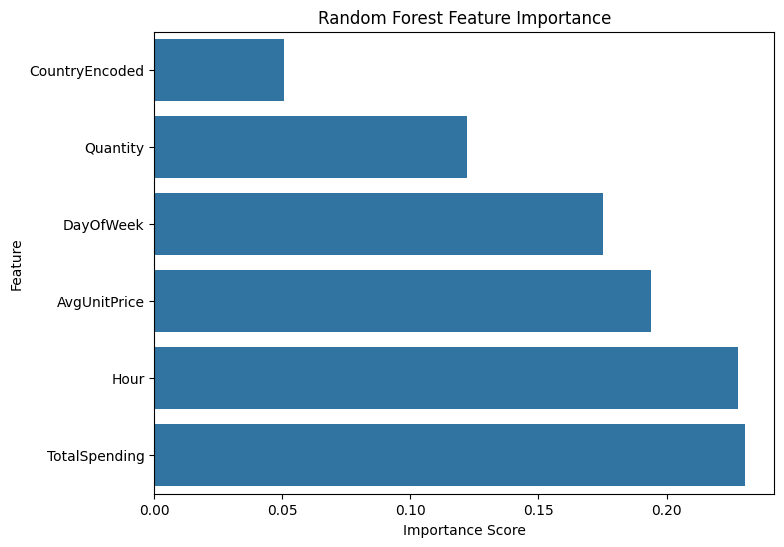

In [17]:
feat_importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(8, 6))
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()


# Key Takeaways
-  Realistic, deployable repeat purchase model
We built a practical, leakage-free pipeline that predicts whether a new customer will become a repeat buyer using only first-order purchase data. This ensures the prediction is realistic and can be deployed immediately after a customer’s first transaction.
- Best-performing algorithm: Random Forest
After comparing multiple models — including Logistic Regression, Decision Tree, XGBoost, and Random Forest — we selected Random Forest as the final algorithm. It delivers robust results with minimal tuning, handles class imbalance naturally, and provides clear feature importance that business teams can act on.
- Practical performance with business value
The final Random Forest model achieves an overall test accuracy of ~59%, correctly identifying 76% of repeat buyers (recall) with a precision of 66%. This means the model reliably flags most customers likely to return, enabling targeted retention offers, personalized onboarding, or loyalty incentives to boost customer lifetime value.
- Transparent insights
Feature importance analysis shows which early purchase patterns (basket size, spend, timing, country) most strongly predict repeat behavior. This provides actionable guidance for marketing and operations teams.

#  Next steps
1.  Enrich data for better prediction
- Future improvements should include additional customer signals: web/app session data, campaign history, product category segmentation, and customer demographics if available.

2. Deploy & monitor
- Deploy the Random Forest model as a production scoring service to flag new customers in real time, and monitor performance to ensure it remains stable over time.

3. Close the loop with targeted actions
- Integrate the predictions with retention campaigns to deliver personalized offers, track conversion, and continually retrain the model as new data arrives